In [1]:
### SETUP ###
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import joblib
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import random
import matplotlib.pyplot as plt

pd.set_option('future.no_silent_downcasting', True)

data = joblib.load("data/pkls/rgl_df_dict.pkl")

# Load necessary data

players = data['players']
teams = data['team_stats']


info = data['info']

## Medic

In [95]:
team_medic_stats = data['team_medic_stats']

medic = players[players['primary_class'] == 'medic']
medic = medic.sort_values(by = 'primary_class',ascending = False)

medic = medic.groupby(['id','team']).first().reset_index()

# Turn some columns into rates that arent rates yet
cols_to_rate = ['medicstats.deaths_with_95_99_uber','medicstats.deaths_within_20s_after_uber']

for col in cols_to_rate:
    s = col + "_rate"
    divisor = team_medic_stats['medic_deaths'].replace(0,np.nan)
    team_medic_stats[s] = team_medic_stats[col].div(divisor).astype(float).round(4)

cols = ['id','team','medicstats.avg_time_before_healing',
       'medicstats.avg_time_before_using', 'medicstats.avg_time_to_build',
       'medicstats.avg_uber_length', 'medicstats.biggest_advantage_lost',
       'medicstats.deaths_with_95_99_uber_rate','drops_rate',
       'medicstats.deaths_within_20s_after_uber_rate','round_losing_medic_death_rate']



team_medic_stats = team_medic_stats[cols]

medic = medic.replace(np.nan,0)

team_medic_stats = team_medic_stats.replace(np.nan,0)

medic = medic.merge(team_medic_stats,on = ['id','team'],how = "left")

# Drop from corr mat
drop_cols = ['total_time','ka','hr_pct','hr',
             'hroi','hroi_real','dmg_pct','medkits',
              'steamid', 'primary_class',
             'primary_class_time','name','dmg_real',
             "offclass_time",'heal','total_time',
             'offclass_pct','dmg_real_pct','ka_pct',
             'drops','deaths','sentries',
             'round_losing_medic_death_rate','suicides']


medic = medic.drop(drop_cols,axis = 1)

# test = medic.corr()
# for i in test.index:
#     for j in test.columns:
#         if test.loc[i,j] > .8 and test.loc[i,j] != 1:
#             s = f'{i} x {j}: {test.loc[i,j].round(4)}'
#             print(s)

medic = medic.merge(
    teams[['id', 'winner', 'team']].replace(np.nan, 0),
    on=['id', 'team']
)

medic = medic.drop(['id', 'team'],axis = 1)
medic = medic.apply(pd.to_numeric)

## Data Manip for combat classes

In [122]:

# Drop unnecessary / highly correlated columns
drop_cols = ['primary_class_time', 'assists',
       'cpc','deaths', 'dmg', 'dmg_real', 'drops', 'dt',
       'dt_real', 'heal', 'hr','kills','medkits','sentries',
       'ka','name','offclass_time','kapd','kpd','kill_pct','total_time','healps']


# Only players who played scout,soldier,demo

combat_classes = players.drop(drop_cols,axis = 1)
combat_class_names = ['scout','soldier','demoman']
combat_classes = combat_classes[combat_classes['primary_class'].isin(combat_class_names)]

# Merge on winner
combat_classes = combat_classes.merge(
    teams[['id', 'winner', 'team']].replace(np.nan, 0),
    on=['id', 'team']
)

# Reorder cols
reorder_cols = ['id','steamid','team','primary_class','winner']
combat_classes = combat_classes[ reorder_cols + [col for col in combat_classes.columns if col not in reorder_cols]]

 # Prepare X for modeling
combat_classes = combat_classes.replace(np.nan,0)

### ADD BACK LATER ####
#combat_classes.drop(['id','steamid','team',],axis = 1,inplace = True)

# cols_to_convert = combat_classes.columns.difference(['primary_class'])
# combat_classes[cols_to_convert] = combat_classes[cols_to_convert].apply(pd.to_numeric)

In [97]:
## Initialize Dictionaries ##

classes = ['medic'] + combat_class_names 

xgb_dict = {class_name: None for class_name in classes}

X_test_dict = {class_name: None for class_name in classes}

y_test_dict = {class_name: None for class_name in classes}

X_eval_dict = {class_name: None for class_name in classes}


y_eval_dict = {class_name: None for class_name in classes}


## Modeling

In [98]:

seed = 123

for class_name in classes:
    print(class_name)

    # Last data manips before modeling
    if class_name != 'medic':
        X = combat_classes.copy()
        X = X[X['primary_class'] == class_name]
        y = X['winner']
        X.drop(['primary_class','winner'],axis = 1,inplace = True)
    elif class_name == 'medic':
        X = medic.copy()
        y = X['winner']
        X.drop(['winner'],axis = 1,inplace = True)        

    
    # Split into test and eval
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    X_test, X_eval, y_test, y_eval = train_test_split(X_test, y_test, test_size=0.3)

    # Set seeds
    random.seed(seed)
    np.random.seed(seed)


    # Define the base model
    model = XGBClassifier(eval_metric='logloss', random_state=seed)

    # Define parameter grid to search over
    param_grid = {
        'max_depth': [2,3,4,5,6,7],
        'learning_rate': [0.1, 0.2],
        'n_estimators': [100],
        'subsample': [0.7, 1.0],
        'colsample_bytree': [0.4,0.5,0.6,0.7]
    }

    # Define cross-validation strategy
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

    # Set up GridSearchCV
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='accuracy',   # or other metrics like 'roc_auc' for binary
        cv=cv,
        verbose=0,
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_

    xgb_dict[class_name] = best_model

    X_test_dict[class_name] = X_test

    y_test_dict[class_name] = y_test

    y_eval_dict[class_name] = y_eval

    X_eval_dict[class_name] = X_eval


medic
scout
soldier
demoman


## Calculating PER Distributions

In [99]:
summary_dict = {class_name: None for class_name in classes}

pred_prob_dict = {class_name: None for class_name in classes}

beta_dict = {class_name: None for class_name in classes}


from scipy.stats import beta

for class_name in classes:
    ## PREPROCESS ##


    model = xgb_dict[class_name]

    importance = pd.Series(model.feature_importances_,name = "importance")
    feature_names = pd.Series(model.feature_names_in_,name = "name")
    summary = pd.concat([feature_names,importance],axis = 1).sort_values(by = 'importance',ascending=False)

    X_test = X_test_dict[class_name]
    y_test = y_test_dict[class_name]

    # Grab necessary vars
    score = model.score(X_test,y_test)
    probs = model.predict_proba(X_test)
    probs = (probs[:,1])

    # Assign values to dict 
    summary['score'] = score
    summary_dict[class_name] = summary
    pred_prob_dict[class_name] = probs


    ## CALCULATE DISTRIBUTION ##
    # Calculate Beta Dist
    a, b, loc, scale = beta.fit(probs, floc=0, fscale=1)  # force within [0,1]
    samples = beta.rvs(a, b, loc=loc, scale=scale, size=100000)

    print(scale)
    beta_params = {
        "a": a,
        "b": b,
        "loc": loc,
        "scale": scale,
        "samples": samples
    }

    beta_dict[class_name] = beta_params



1
1
1
1


## Calculate PER on EVAL_set

In [100]:
PER_dict = {class_name:None for class_name in classes}

for class_name in classes:
    # Grab variables
    X_eval = X_eval_dict[class_name]
    y_eval = y_eval_dict[class_name]
    a = beta_dict[class_name]['a']
    b = beta_dict[class_name]['b']
    loc = beta_dict[class_name]['loc']
    scale = beta_dict[class_name]['scale']
    model = xgb_dict[class_name]
    
    # Calculate Probs
    probs = model.predict_proba(X_eval)
    probs = probs[:,1]

    #Calculate Quantiles
    beta_quantile = beta.cdf(probs, a, b, loc=loc, scale=scale)

    
    probs = pd.Series(probs)
    beta_quantile = pd.Series(beta_quantile)


    probs_df = pd.concat([probs,beta_quantile],axis = 1)

    probs_df.columns = ['pred_prob','beta_quantile']

    probs_df['PER_beta'] = (probs_df['beta_quantile'] * 10).round(1)
    PER_dict[class_name] = probs_df


In [ ]:
a = X_eval_dict['demoman']

per = PER_dict['demoman']["PER_beta"].values

a['PER'] = per

a['winner'] = y_eval_dict['demoman'].values

In [180]:
a['winner']

7063     0.0
1436     1.0
6775     1.0
10989    0.0
8658     1.0
        ... 
3958     0.0
9954     1.0
20168    0.0
19980    0.0
15889    0.0
Name: winner, Length: 404, dtype: float64

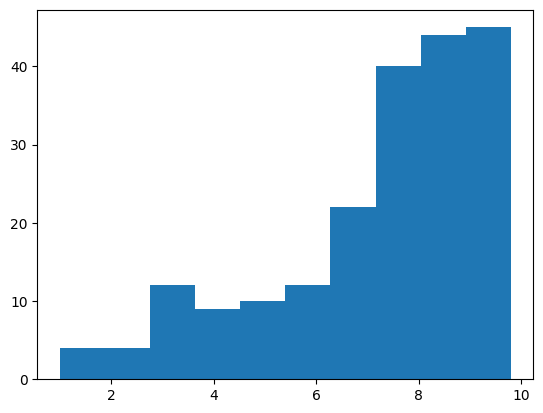

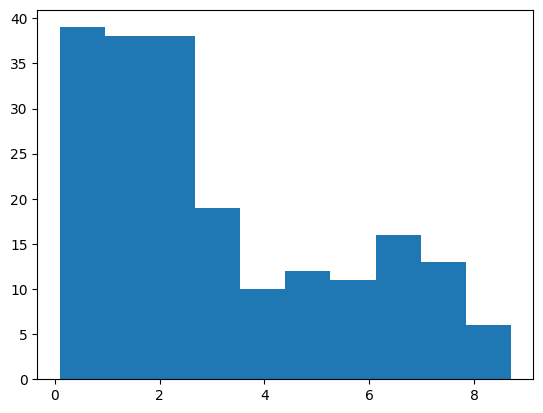

In [182]:
plt.hist(a[a['winner'] == 1]['PER'])
plt.show()

plt.hist(a[a['winner'] == 0]['PER'])
plt.show()

In [101]:
a = X_eval_dict['scout']

a['winner'] = y_eval_dict['scout']

In [102]:
a['PER'] = PER_dict['scout']['PER_beta'].values

In [103]:
a.groupby('winner').agg(PER_av = ("hroi","mean"))

,PER_av
winner,
0.0,1.364932
1.0,1.569654


In [104]:
a

,dapd,dapm,medkits_hp,suicides,offclass_pct,deaths_pct,dmg_pct,dmg_real_pct,cpc_pct,ka_pct,assists_pct,dt_pct,dt_real_pct,hr_pct,hroi,hroi_real,winner,PER
4630,598,266,302,0,0.0255,0.1628,0.1844,0.1625,0.7500,0.2696,0.3111,0.1627,0.2086,0.1677,1.551315,0.166728,1.0,9.6
9220,509,317,962,0,0.0000,0.1554,0.2171,0.1445,0.3913,0.1970,0.1646,0.1602,0.1615,0.1890,1.434570,0.075407,0.0,5.6
14042,274,164,587,0,0.1123,0.2188,0.1635,0.1698,0.6818,0.1635,0.1200,0.1563,0.2226,0.0791,2.614441,0.325159,1.0,6.6
1102,339,182,666,0,0.1747,0.2016,0.1545,0.2097,0.6061,0.1730,0.1860,0.1384,0.1912,0.1332,1.330668,0.179514,1.0,7.6
11686,241,146,60,0,0.0000,0.1154,0.1555,0.0804,0.0000,0.1818,0.0000,0.1379,0.1333,0.1692,0.819209,0.020339,0.0,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6472,334,260,421,0,0.0000,0.1613,0.1809,0.0721,0.5000,0.2105,0.3333,0.1582,0.1255,0.1598,1.908571,0.070857,0.0,1.6
6851,407,264,669,0,0.0152,0.1770,0.1601,0.1285,0.1500,0.1733,0.1857,0.1323,0.1694,0.1633,1.435387,0.100000,1.0,7.5
963,249,182,172,0,0.1730,0.2344,0.1413,0.1713,0.2857,0.1579,0.1622,0.1339,0.2629,0.1376,1.339305,0.207094,1.0,7.2
14310,296,203,663,0,0.0000,0.1364,0.1503,0.0830,0.6667,0.1980,0.2564,0.1084,0.1710,0.1369,1.852635,0.094076,0.0,1.6


In [105]:
X_eval_dict['demoman'].reset_index().loc[[3,5],:]

,index,dapd,dapm,medkits_hp,suicides,offclass_pct,deaths_pct,dmg_pct,dmg_real_pct,cpc_pct,ka_pct,assists_pct,dt_pct,dt_real_pct,hr_pct,hroi,hroi_real
3,10989,462,272,1132,0,0.0,0.1466,0.2279,0.1492,0.4211,0.0987,0.0566,0.2137,0.1238,0.2974,0.866762,0.053780
5,18588,915,350,943,0,0.0,0.1569,0.2619,0.2414,0.3500,0.1596,0.1667,0.2459,0.0904,0.2851,1.076267,0.080088


In [107]:
PER_dict['demoman']

,pred_prob,beta_quantile,PER_beta
0,0.208285,0.308546,3.1
1,0.484261,0.496291,5.0
2,0.875040,0.773380,7.7
3,0.012833,0.076099,0.8
4,0.765029,0.682375,6.8
...,...,...,...
399,0.734560,0.660229,6.6
400,0.985500,0.924374,9.2
401,0.695551,0.633006,6.3
402,0.142838,0.253352,2.5


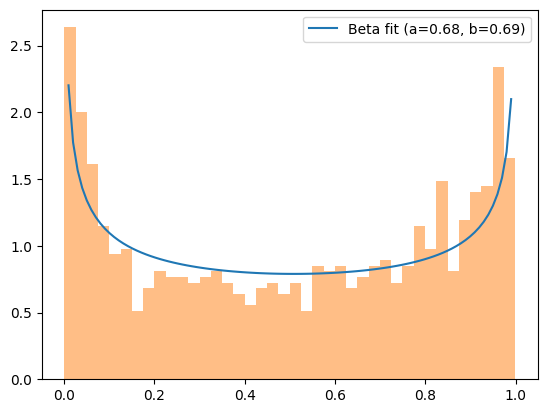

In [10]:
from scipy.stats import beta
a, b, loc, scale = beta.fit(probs, floc=0, fscale=1)  # force within [0,1]

x = np.linspace(0, 1, 100)
pdf = beta.pdf(x, a, b, loc=loc, scale=scale)

plt.plot(x, pdf, label=f'Beta fit (a={a:.2f}, b={b:.2f})')
plt.hist(probs, bins=40, density=True, alpha=0.5)
plt.legend()
plt.show()
